# Movie netowork analysis(Basic metrics) 

Links to official tutorials:
1. https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/Introduction_to_ConvoKit.ipynb
2. https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/vectors/vector_demo.ipynb
3. https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/text-processing/text_preprocessing_demo.ipynb
4.https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/convokit/tests/notebook_testers/test_corpus_partial_load.ipynb
5. https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/merging/corpus_merge_demo.ipynb
6. Use the movie dialo corpus: https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/sigdial-demo.ipynb

issue: the first utterance of a conversation.

In [1]:
import spacy
from convokit import Corpus, download
import numpy as np
import networkx as nx
from node2vec import Node2Vec
from tqdm import tqdm
import pandas as pd

In [2]:
nlp = spacy.load('en_core_web_sm')

In [3]:
def tokenizer_spacy(text, lemma=False):
    doc = nlp(text)
    article = []
    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article!
        if w.text != '\n' and not w.is_punct and not w.like_num:
            if lemma:
              # we add the lematized version of the word
              article.append(w.lemma_)
            else:
              article.append(w.text)
    return article

### Dataset

In [4]:
corpus = Corpus(filename=download("movie-corpus"))
corpus.print_summary_stats()

Number of Speakers: 9035
Number of Utterances: 304713
Number of Conversations: 83097


In [67]:
corpus.get_speakers_dataframe().head()

,vectors,meta.character_name,meta.movie_idx,meta.movie_name,meta.gender,meta.credit_pos
id,,,,,,
u0,[],BIANCA,m0,10 things i hate about you,f,4
u2,[],CAMERON,m0,10 things i hate about you,m,3
u3,[],CHASTITY,m0,10 things i hate about you,?,?
u4,[],JOEY,m0,10 things i hate about you,m,6
u5,[],KAT,m0,10 things i hate about you,f,2


In [68]:
corpus.get_utterances_dataframe().head()

,timestamp,text,speaker,reply_to,conversation_id,meta.movie_id,meta.parsed,vectors
id,,,,,,,,
L1045,None,They do not!,u0,L1044,L1044,m0,"[{'rt': 1, 'toks': [{'tok': 'They', 'tag': 'PR...",[]
L1044,None,They do to!,u2,None,L1044,m0,"[{'rt': 1, 'toks': [{'tok': 'They', 'tag': 'PR...",[]
L985,None,I hope so.,u0,L984,L984,m0,"[{'rt': 1, 'toks': [{'tok': 'I', 'tag': 'PRP',...",[]
L984,None,She okay?,u2,None,L984,m0,"[{'rt': 1, 'toks': [{'tok': 'She', 'tag': 'PRP...",[]
L925,None,Let's go.,u0,L924,L924,m0,"[{'rt': 0, 'toks': [{'tok': 'Let', 'tag': 'VB'...",[]


In [69]:
corpus.get_conversations_dataframe().head()

,vectors,meta.movie_idx,meta.movie_name,meta.release_year,meta.rating,meta.votes,meta.genre
id,,,,,,,
L1044,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
L984,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
L924,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
L870,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"
L866,[],m0,10 things i hate about you,1999,6.90,62847,"['comedy', 'romance']"


In [5]:
# corpus.get_utterance('L506573')
# the lines ids are not sequential. Some are skipped. 

### Preparations and Constructing networks

Using number of lines to construct networks.
We may use other ways to construct egdes in the future. 

In [56]:
def get_movie_utt_dic(corpus):
    '''
    get the dictionary of movies that map movies to corresponding utterances. 
    In chronological order. 
    '''
    movie_utt_dic = {}
    movie_idx_name = {}
    for utt in tqdm(corpus.iter_utterances()):
        if utt.meta['movie_id'] not in movie_utt_dic:
            movie_utt_dic[utt.meta['movie_id']] = []
            movie_idx_name[utt.meta['movie_id']] = utt.speaker.meta['movie_name']
        movie_utt_dic[utt.meta['movie_id']].append(int(utt.id[1:]))
    
    for movie, utt_lst in tqdm(movie_utt_dic.items()):
        id_lst = sorted(utt_lst)
        movie_utt_dic[movie] =  ['L' + str(i) for i in id_lst]
    
    return movie_utt_dic, movie_idx_name
        
movie_utt_dic, movie_idx_name = get_movie_utt_dic(corpus)
# movie_utt_dic['m180'], movie_idx_name['m180']

304713it [00:02, 117008.78it/s]
100%|███████████████████████████████████████| 617/617 [00:00<00:00, 4017.60it/s]


In [57]:
def get_characters_from_one_movie(corpus, movie_utt_dic, movie_idx, lemma=False):
    '''
    get lines for characters.Using lemmatized lines when using models like word2vec. 
    '''
    characters = {}
    characters_attrs = {}
    
    for utt_id in movie_utt_dic[movie_idx]:
        utt = corpus.get_utterance(utt_id)
        speaker = utt.speaker
        if speaker.meta['movie_idx'] == movie_idx:
            if speaker.id not in characters:
                characters[speaker.id] = []
                characters_attrs[speaker.id] = {'character_name': speaker.meta['character_name'],
                                                'gender': speaker.meta['gender'],
                                                'credit_pos':speaker.meta['credit_pos']}
        text = utt.text
        if lemma: 
            text = tokenizer_spacy(text)
        characters[speaker.id].append(text)
    return characters, characters_attrs

characters, characters_attrs = get_characters_from_one_movie(corpus, movie_utt_dic,'m180')
characters['u2750'], characters_attrs['u2750']

(['Posse? What the hell you talking about?',
  "You brought a posse to my best hideout and you want to know if I mind. Mister, I don't know any of those names and you're about to die.",
  'No money, eh?',
  'What do you mean, the horses?'],
 {'character_name': 'DAWSON', 'gender': '?', 'credit_pos': '?'})

In [58]:
def create_nodes(characters, characters_attrs, num_lines=0):
    '''
    creating nodes for networks using number of lines as the criteria.
    '''
    actor_network = nx.DiGraph()
    for character in characters:
        if len(characters[character]) > num_lines:
            actor_network.add_node(characters_attrs[character]['character_name'], 
                                   gender= characters_attrs[character]['gender'],
                                   credit_pos = characters_attrs[character]['credit_pos'],
                                   lines_spoken= len(characters[character]), 
                                   u_id = character,
                                   words=characters[character])
    return actor_network

def create_nodes_num(characters, characters_attrs, num_lines=0):
    '''
    creating nodes for networks using number of lines as the criteria.
    '''
    actor_network = nx.DiGraph()
    i = 0
    for character in characters:
        if len(characters[character]) > num_lines:
            actor_network.add_node(i, 
                                   gender= characters_attrs[character]['gender'],
                                   credit_pos = characters_attrs[character]['credit_pos'],
                                   lines_spoken= len(characters[character]), 
                                   words=characters[character])
            i += 1
    return actor_network

actor_network = create_nodes(characters, characters_attrs, num_lines=0)
actor_network.nodes()

NodeView(('EMMETT', 'PADEN', 'SHERIFF COBB', 'HOBART', 'LANGSTON', 'PROPRIETOR', 'MAL', 'JAKE', 'DAWSON', 'HANNAH', 'EZRA', 'KATE', 'J.T.', 'STELLA', 'KELLY', 'RAE', 'MCKENDRICK'))

In [59]:
def create_edges(corpus, utt_id_lst, characters, actor_network):
    '''
    Using 'reply to' and the number of lines as weights to create egdes.
    Directed. 
    '''
    for utt_id in utt_id_lst:
        utt = corpus.get_utterance(utt_id)
        speaker1 = utt.speaker.meta['character_name']
        speaker1_id = utt.speaker.id
        if speaker1_id in characters and speaker1 in actor_network.nodes():
            if utt.reply_to is not None:
                speaker2 = corpus.get_utterance(utt.reply_to).speaker.meta['character_name']
                speaker2_id = corpus.get_utterance(utt.reply_to).speaker.id
                if speaker2_id in characters and speaker2 in actor_network.nodes() and speaker2 != speaker1:
                    if (speaker1, speaker2) not in actor_network.edges():          
                        actor_network.add_edge(speaker1, speaker2, weight=0)
                    if (speaker1, speaker2) in actor_network.edges():
                        actor_network.edges[(speaker1, speaker2)]['weight'] += 1
    return actor_network
                        
actor_network = create_edges(corpus, movie_utt_dic['m180'], characters, actor_network)
actor_network.edges.data()

OutEdgeDataView([('EMMETT', 'PADEN', {'weight': 23}), ('EMMETT', 'HOBART', {'weight': 3}), ('EMMETT', 'LANGSTON', {'weight': 4}), ('EMMETT', 'JAKE', {'weight': 6}), ('EMMETT', 'DAWSON', {'weight': 3}), ('EMMETT', 'MAL', {'weight': 7}), ('EMMETT', 'HANNAH', {'weight': 10}), ('EMMETT', 'MCKENDRICK', {'weight': 4}), ('PADEN', 'EMMETT', {'weight': 19}), ('PADEN', 'SHERIFF COBB', {'weight': 20}), ('PADEN', 'LANGSTON', {'weight': 4}), ('PADEN', 'JAKE', {'weight': 10}), ('PADEN', 'HANNAH', {'weight': 5}), ('PADEN', 'MAL', {'weight': 4}), ('PADEN', 'STELLA', {'weight': 17}), ('SHERIFF COBB', 'PADEN', {'weight': 16}), ('SHERIFF COBB', 'STELLA', {'weight': 3}), ('SHERIFF COBB', 'KELLY', {'weight': 4}), ('SHERIFF COBB', 'MCKENDRICK', {'weight': 2}), ('HOBART', 'EMMETT', {'weight': 4}), ('LANGSTON', 'PROPRIETOR', {'weight': 3}), ('LANGSTON', 'MAL', {'weight': 3}), ('LANGSTON', 'PADEN', {'weight': 3}), ('LANGSTON', 'EMMETT', {'weight': 3}), ('PROPRIETOR', 'LANGSTON', {'weight': 2}), ('MAL', 'LANGST

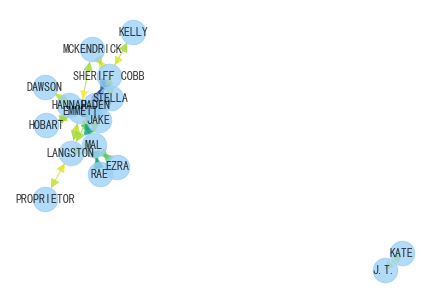

In [60]:
pos = nx.spring_layout(actor_network,k=0.55,iterations=20)
edges,weights = zip(*nx.get_edge_attributes(actor_network,'weight').items())
weights = np.array(weights)
#weights = weights*weights
weights = 6*weights/np.max(weights)
edge_colors=20*(weights/np.max(weights))
edge_colors = edge_colors.astype(int)

nx.draw(actor_network, with_labels=True, width=weights, 
        font_weight='bold', edge_color=255-edge_colors, 
        node_color='#99cef7',node_size=600, alpha=0.75, arrowsize=20)

#### Some available metrics

In [ ]:
nx.degree_centrality(actor_network)
#  directed graph does not have centrality

In [ ]:
nx.betweenness_centrality(actor_network)

In [ ]:
dir(actor_network)

In [ ]:
[i for i in actor_network.neighbors('PADEN')] 

In [ ]:
actor_network.out_degree()

In [ ]:
actor_network.out_degree(weight = 'weight')

In [ ]:
actor_network.out_degree(weight = 'weight')['VEREKER']

In [ ]:
actor_network.in_degree(weight = 'weight')

In [ ]:
nx.density(actor_network)

In [ ]:
pd.DataFrame(actor_network.in_degree(weight = 'weight'), columns=['name', 'In degree'])

### Get networks for all movies

In [96]:
all_networks = {}

movie_utt_dic, movie_idx_name = get_movie_utt_dic(corpus)

for movie_idx in movie_utt_dic.keys():
    characters, characters_attrs = get_characters_from_one_movie(corpus, movie_utt_dic, movie_idx)
    actor_network = create_nodes(characters, characters_attrs, num_lines=0)
    actor_network = create_edges(corpus, movie_utt_dic[movie_idx], characters, actor_network)
    all_networks[movie_idx] = actor_network

304713it [00:02, 104589.24it/s]
100%|███████████████████████████████████████| 617/617 [00:00<00:00, 4387.52it/s]


### Average lines spoken of female/male characters

In [62]:
female_character_lines = []
male_character_lines = []
for network in tqdm(all_networks.values()):
    for character in network.nodes():
        if network.nodes[character]['gender'].lower() == 'f':
            female_character_lines.append(network.nodes[character]['lines_spoken'])
        if network.nodes[character]['gender'].lower() == 'm':
            male_character_lines.append(network.nodes[character]['lines_spoken'])

100%|██████████████████████████████████████| 617/617 [00:00<00:00, 35903.46it/s]


In [63]:
len(female_character_lines), len(male_character_lines)

(966, 2049)

In [64]:
sum(female_character_lines)/len(female_character_lines)

73.76293995859213

In [65]:
sum(male_character_lines)/len(male_character_lines)

83.34211810639336

### Average lines spoken of main female/male characters

In [ ]:
speaker_df = corpus.get_speakers_dataframe()

In [67]:
position_mask = (speaker_df['meta.credit_pos'] == str(1)) 
speaker_df[position_mask]

,vectors,meta.character_name,meta.movie_idx,meta.movie_name,meta.gender,meta.credit_pos
id,,,,,,
u9,[],PATRICK,m0,10 things i hate about you,m,1
u16,[],COLUMBUS,m1,1492: conquest of paradise,m,1
u29,[],EDDIE,m2,15 minutes,m,1
u50,[],BOWMAN,m3,2001: a space odyssey,m,1
u67,[],CATES,m4,48 hrs.,m,1
...,...,...,...,...,...,...
u8950,[],DOROTHY,m610,the wizard of oz,f,1
u8965,[],BOND,m611,the world is not enough,m,1
u8970,[],M,m611,the world is not enough,m,1


In [70]:
main_female_character_lines = []
main_male_character_lines = []

for idx, row in speaker_df[position_mask].iterrows():
    network = all_networks[row['meta.movie_idx']]
    for character in network.nodes():
        if network.nodes[character]['gender'].lower() == 'f' and\
        network.nodes[character]['u_id'] == idx:
            main_female_character_lines.append(network.nodes[character]['lines_spoken'])
        if network.nodes[character]['gender'].lower() == 'm' and\
        network.nodes[character]['u_id'] == idx:
            main_male_character_lines.append(network.nodes[character]['lines_spoken'])  

In [71]:
len(main_female_character_lines), len(main_male_character_lines)

(89, 408)

In [72]:
sum(main_female_character_lines)/len(main_female_character_lines)

150.19101123595505

In [73]:
sum(main_male_character_lines)/len(main_male_character_lines)

162.39460784313727

### Average in/out degree of female/male characters

In [79]:
female_character_in = []
male_character_in = []
female_character_out = []
male_character_out = []

for network in tqdm(all_networks.values()):
    for character in network.nodes():
        if network.nodes[character]['gender'].lower() == 'f':
            female_character_in.append(network.in_degree(weight = 'weight')[character])
            female_character_out.append(network.out_degree(weight = 'weight')[character])
        if network.nodes[character]['gender'].lower() == 'm':
            male_character_in.append(network.in_degree(weight = 'weight')[character])
            male_character_out.append(network.out_degree(weight = 'weight')[character])

100%|███████████████████████████████████████| 617/617 [00:00<00:00, 8787.39it/s]


In [81]:
sum(female_character_in)/len(female_character_in)

54.939958592132506

In [82]:
sum(female_character_out)/len(female_character_out)

54.12215320910973

In [83]:
sum(male_character_in)/len(male_character_in)

60.2464616886286

In [84]:
sum(male_character_out)/len(male_character_out)

61.18984870668619

### Average in/out degree of main female/male characters

In [85]:
main_female_character_in = []
main_male_character_in = []
main_female_character_out = []
main_male_character_out = []

for idx, row in speaker_df[position_mask].iterrows():
    network = all_networks[row['meta.movie_idx']]
    for character in network.nodes():
        if network.nodes[character]['gender'].lower() == 'f' and\
        network.nodes[character]['u_id'] == idx:
            main_female_character_in.append(network.in_degree(weight = 'weight')[character])
            main_female_character_out.append(network.out_degree(weight = 'weight')[character])
        if network.nodes[character]['gender'].lower() == 'm' and\
        network.nodes[character]['u_id'] == idx:
            main_male_character_in.append(network.in_degree(weight = 'weight')[character])
            main_male_character_out.append(network.out_degree(weight = 'weight')[character])

In [86]:
sum(main_female_character_in)/len(main_female_character_in)

110.8314606741573

In [87]:
sum(main_female_character_out)/len(main_female_character_out)

113.06741573033707

In [88]:
sum(main_male_character_in)/len(main_male_character_in)

117.33823529411765

In [89]:
sum(main_male_character_out)/len(main_male_character_out)

121.37009803921569

### Betweeness centrality of female/male characters

In [90]:
female_character_bc = []
male_character_bc = []

for network in tqdm(all_networks.values()):
    for character in network.nodes():
        if network.nodes[character]['gender'].lower() == 'f':
            female_character_bc.append(nx.betweenness_centrality(network)[character])
        if network.nodes[character]['gender'].lower() == 'm':
            male_character_bc.append(nx.betweenness_centrality(network)[character])

100%|████████████████████████████████████████| 617/617 [00:01<00:00, 331.54it/s]


In [91]:
sum(female_character_bc)/len(female_character_bc)

0.13961195087182046

In [92]:
sum(male_character_bc)/len(male_character_bc)

0.21194134790379401

### Betweeness centrality of main female/male characters

In [93]:
main_female_character_bc = []
main_male_character_bc = []

for idx, row in speaker_df[position_mask].iterrows():
    network = all_networks[row['meta.movie_idx']]
    for character in network.nodes():
        if network.nodes[character]['gender'].lower() == 'f' and\
        network.nodes[character]['u_id'] == idx:
            main_female_character_bc.append(nx.betweenness_centrality(network)[character])
        if network.nodes[character]['gender'].lower() == 'm' and\
        network.nodes[character]['u_id'] == idx:
            main_male_character_bc.append(nx.betweenness_centrality(network)[character])

In [94]:
sum(main_female_character_bc)/len(main_female_character_bc)

0.4292583839236682

In [95]:
sum(main_male_character_bc)/len(main_male_character_bc)

0.5360182954714627